<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Model Optimization (MO) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">Required Imports</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">Package Descriptions</h3>
<ul style="font-family: 'Arial', sans-serif;">
    <li><strong>pandas</strong>: For data manipulation and analysis, enabling easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: To create data visualizations and plots.</li>
    <li><strong>seaborn</strong>: For generating attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand data quality.</li>
</ul>


In [38]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
from scipy import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import accuracy_score, f1_score, classification_report # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore
from imblearn.over_sampling import SMOTE # type: ignore
from catboost import CatBoostClassifier, Pool # type: ignore
from sklearn.model_selection import KFold, StratifiedKFold # type: ignore
import joblib # type: ignore
import os # type: ignore
from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, BatchNormalization # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #type: ignore
import logging #type: ignore
import time  #type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight



import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section handles loading the dataset into the environment for further processing. Using <strong>pandas</strong>, we load the data into a structured dataframe, allowing for easy manipulation, exploration, and analysis throughout the project.
</p>


In [14]:
path = "../data/"

data_train_FS = pd.read_csv(path + "data_train_post_FS.csv")
data_test_FS = pd.read_csv(path + "data_test_post_FS.csv")

combined_data = pd.concat([data_train_FS, data_test_FS], keys=['train', 'test'])

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Model Selection
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section focuses on selecting the best-performing models for predicting workers' compensation claims outcomes. Various machine learning algorithms are evaluated based on their accuracy, interpretability, and suitability for the dataset, ensuring an optimal balance between predictive performance and computational efficiency.
</p>


In [15]:
x_FS = data_train_FS.drop(['Claim Identifier', 'Claim Injury Type'], axis=1)
y_FS = data_train_FS['Claim Injury Type']

X_train_FS, X_val_FS, y_train_FS, y_val_FS = train_test_split(x_FS, y_FS, test_size=0.25)

In [16]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_FS, y_train_FS)

KeyboardInterrupt: 

<h1 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1;">
    Data into CatBoost Pool Format
</h1>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; color: #4A90E2; text-align: justify;">
    The <strong style="color: #3498db;">CatBoost</strong> library uses a specific data structure called a <code>Pool</code> to store datasets for training and evaluation.
    Converting data into a <code>Pool</code> format helps CatBoost optimize and process the data efficiently, 
    which is especially beneficial for handling categorical features and large datasets.
</p>


In [ ]:
# Convert data into CatBoost Pool format
train_data = Pool(X_train_resampled, y_train_resampled)
val_data = Pool(X_val_FS, y_val_FS)

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">CatBoostClassifier Model Explanation</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; color: #4A90E2;">
    The <strong>CatBoostClassifier</strong> is a powerful machine learning model from the <strong>CatBoost</strong> library that is particularly effective for handling categorical features and large datasets. It is based on <strong>gradient boosting</strong>, which sequentially builds trees to correct errors made by previous ones.
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">Key Components of the Model:</h4>

<ul style="font-family: 'Arial', sans-serif; line-height: 1.8; color: #4A90E2;">
    <li><strong>iterations=250</strong>: This specifies the number of boosting iterations (trees) to be built. In this case, the model will build 250 trees unless <strong>early stopping</strong> is triggered earlier.</li>
    <li><strong>early_stopping_rounds=10</strong>: This is a regularization technique used to prevent overfitting. The model will stop training if the validation loss does not improve for 10 consecutive iterations (rounds). This helps to avoid unnecessary computation and ensures that the model doesn't overfit to the training data.</li>
    <li><strong>eval_metric="MultiClass"</strong>: The evaluation metric used to track the model’s performance during training. In this case, it is set to <strong>MultiClass</strong>, which is appropriate for classification problems where there are multiple classes (categories) in the target variable.</li>
    <li><strong>verbose=False</strong>: This suppresses output during training. If set to <strong>True</strong>, the model will print details of each iteration. In this case, setting it to <strong>False</strong> prevents cluttering the console during the training process.</li>
    <li><strong>model.fit(train_data, eval_set=val_data, verbose=10)</strong>: This is the <strong>training step</strong> where the model is fitted to the training data (<code>train_data</code>). <strong>eval_set=val_data</strong> specifies that <code>val_data</code> is used for <strong>validation</strong> during training. The model's performance on this data is tracked to monitor overfitting and make adjustments accordingly. <strong>verbose=50</strong> will print the evaluation results every 50 iterations during training, which helps to monitor the progress of the training process without printing too frequently.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; color: #4A90E2;">
    <strong>Conclusion:</strong> By using <strong>early stopping</strong> and <strong>validation data</strong>, the CatBoost model ensures efficient training while avoiding overfitting. The <code>eval_metric="MultiClass"</code> helps monitor performance for multi-class classification problems. This setup ensures that the model generalizes well and doesn't memorize the training data.
</p>

In [ ]:
# Fit model with validation data to track validation loss
model = CatBoostClassifier(iterations=500, early_stopping_rounds=10, eval_metric="MultiClass", verbose=False)
model.fit(train_data, eval_set=val_data, verbose=50)

Learning rate set to 0.296188
0:	learn: 1.0410769	test: 1.2249157	best: 1.2249157 (0)	total: 3s	remaining: 4m 56s
50:	learn: 0.4028857	test: 0.6045438	best: 0.6045438 (50)	total: 1m 28s	remaining: 1m 25s
99:	learn: 0.3808981	test: 0.5815138	best: 0.5815138 (99)	total: 2m 40s	remaining: 0us

bestTest = 0.5815138367
bestIteration = 99



In [ ]:
# Get the loss values for training and validation
train_loss = model.get_evals_result()['learn']['MultiClass']
val_loss = model.get_evals_result()['validation']['MultiClass']

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Training and Validation Loss Over Iterations
</h3>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; color: #4A90E2;">
    The graph illustrates the comparison between the <strong>training loss</strong> and the <strong>validation loss</strong> as the model progresses through its iterations during training. Both loss metrics are plotted against the number of <strong>iterations</strong> (the number of times the model has been trained on the data).
</p>

<h4 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">Key Observations:</h4>
<ul style="font-family: 'Arial', sans-serif; line-height: 1.8; color: #4A90E2;">
    <li><strong>Rapid Decrease in Loss:</strong> Both training and validation losses start high at the beginning of the iterations and rapidly decrease. This suggests that the model is learning and improving during the initial training stages.</li>
    <li><strong>Convergence of Training and Validation Loss:</strong> After a certain point, the training and validation losses become stable and converge. This is typically a sign that the model is reaching its optimal performance, where further training will not result in significant improvements.</li>
    <li><strong>Overfitting Indications:</strong> If there were a sharp divergence between the training and validation losses (where training loss continues to decrease while validation loss starts to increase), this would indicate overfitting, where the model is learning noise or over-adapting to the training data.</li>
    <li><strong>Performance Monitoring:</strong> Monitoring both training and validation loss is essential to ensure that the model is not overfitting and is learning meaningful patterns. In this graph, since both curves are close to each other, it suggests that the model is generalizing well to the validation set.</li>
</ul>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; line-height: 1.6; color: #4A90E2;">
    The graph’s shape and behavior indicate that the model is efficiently learning from the training data and is generalizing well on unseen validation data. It shows a typical pattern of training with early learning, followed by stabilization in performance.
</p>


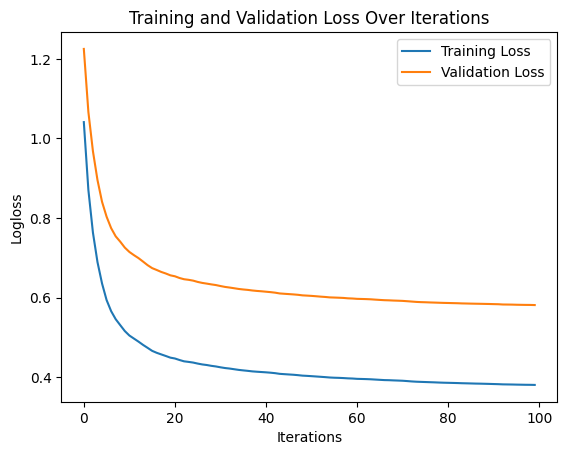

In [ ]:
# Plot training and validation loss
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Logloss")
plt.title("Training and Validation Loss Over Iterations")
plt.legend()
plt.show()

In [ ]:
y_val_pred_XGBC = model.predict(X_val_FS)
f1 = f1_score(y_val_FS, y_val_pred_XGBC, average='macro')

print(classification_report(y_val_FS, y_val_pred_XGBC))
print(f'Validation Accuracy: {accuracy_score(y_val_FS, y_val_pred_XGBC)}')
print("Macro F1 Score:", f1)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     72889
           1       0.72      0.87      0.79     37083
           2       0.50      0.08      0.14     17185
           3       0.69      0.57      0.62     12061
           4       0.41      0.01      0.01      1056
           5       0.74      0.46      0.57      3091
           6       0.69      0.34      0.45       119
           7       0.01      0.09      0.01        23

    accuracy                           0.79    143507
   macro avg       0.58      0.42      0.44    143507
weighted avg       0.76      0.79      0.75    143507

Validation Accuracy: 0.7890486178374574
Macro F1 Score: 0.43843250832433656


In [ ]:
y_test_pred_XGBC = model.predict(data_test_FS.drop(columns=['Claim Identifier']))
y_test_pred_XGBC = y_test_pred_XGBC.ravel()

mapa_codificacao = {
    0: '2. NON-COMP',
    1: '4. TEMPORARY',
    2: '3. MED ONLY',
    3: '5. PPD SCH LOSS',
    4: '6. PPD NSL',
    5: '1. CANCELLED',
    6: '8. DEATH',
    7: '7. PTD',
    8: ''
}

y_pred_codificado_XGBC = [mapa_codificacao[pred] for pred in y_test_pred_XGBC]

data_test_FS['Claim Injury Type'] = y_pred_codificado_XGBC
submission_df = data_test_FS[['Claim Identifier', 'Claim Injury Type']]
submission_df.to_csv('./data/submission_group_40_CatBoost.csv', index=False)

data_test_FS.drop(columns=['Claim Injury Type'], inplace=True)

In [ ]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances.to_csv('./data/features.csv', index=False)

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 2px 2px #D1D1D1;">Teste</h3>

In [41]:
def meta_model(X_train_resampled, y_train_resampled, data_test, n_splits_n=3, num_classes_n=8, verbose=True):
    start_time = time.time()

    model_dir = "../models/"
    predictions_dir = "../predictions/"
    logs_dir = "../logs/"
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(predictions_dir, exist_ok=True)
    os.makedirs(logs_dir, exist_ok=True)

    log_file = os.path.join(logs_dir, 'training_log.txt')
    logging.basicConfig(
        filename=log_file,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )

    logging.info("Início do treinamento do meta_model.")

    kf = StratifiedKFold(n_splits=n_splits_n, shuffle=True, random_state=42)

    oof_predictions = np.zeros((X_train_resampled.shape[0], num_classes_n))
    test_predictions = np.zeros((data_test.shape[0], num_classes_n))
    
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train_resampled), 
        y=y_train_resampled
    )
    class_weights = class_weights.tolist()
        
    models = []
    f1_scores = []

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_resampled, y_train_resampled)):
        if verbose:
            print(f"Training Fold {fold + 1}...")
            logging.info(f"Training Fold {fold + 1}...")

        X_train_fold = X_train_resampled.iloc[train_idx]
        X_valid_fold = X_train_resampled.iloc[valid_idx]
        y_train_fold = y_train_resampled.iloc[train_idx]
        y_valid_fold = y_train_resampled.iloc[valid_idx]

        fold_model = CatBoostClassifier(
            iterations=500,
            class_weights=class_weights,
            eval_metric="MultiClass",
            verbose=25
        )

        fold_model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold), verbose=50)

        oof_predictions[valid_idx] = fold_model.predict_proba(X_valid_fold)
        test_predictions += fold_model.predict_proba(data_test)

        valid_preds = np.argmax(oof_predictions[valid_idx], axis=1)
        fold_f1 = f1_score(y_valid_fold, valid_preds, average='macro')
        f1_scores.append(fold_f1)
        
        report = classification_report(y_valid_fold, valid_preds, target_names=list(mapa_codificacao.values()))
        logging.info(f"Relatório de métricas por classe no Fold {fold + 1}:\n{report}")

        if verbose:
            print(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")
            logging.info(f"Macro F1-Score do Fold {fold + 1}: {fold_f1:.4f}")

        model_filename = os.path.join(model_dir, f"catboost_fold_{fold + 1}.joblib")
        joblib.dump(fold_model, model_filename)

        models.append(fold_model)

    test_predictions /= n_splits_n

    oof_preds_labels = np.argmax(oof_predictions, axis=1)
    oof_f1 = f1_score(y_train_resampled, oof_preds_labels, average='macro')
    logging.info(f"Macro F1-Score do OOF: {oof_f1:.4f}")

    np.save(os.path.join(predictions_dir, "oof_predictions.npy"), oof_predictions)
    np.save(os.path.join(predictions_dir, "test_predictions.npy"), test_predictions)

    end_time = time.time()
    total_time = end_time - start_time
    if verbose:
        print(f"Treinamento concluído em {total_time / 60:.2f} minutos.")
        logging.info(f"Treinamento concluído em {total_time / 60:.2f} minutos.")

    return models, f1_scores, oof_predictions, test_predictions


In [42]:
models, f1_scores, oof_predictions, test_predictions = meta_model(X_train_resampled, y_train_resampled, data_test_FS.drop(columns=['Claim Identifier', 'Claim Injury Type']), 3)

Training Fold 1...
Learning rate set to 0.162049
0:	learn: 1.7134417	test: 1.7134777	best: 1.7134777 (0)	total: 3.92s	remaining: 32m 38s


KeyboardInterrupt: 

In [26]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(oof_predictions, y_train_resampled, test_size=0.2, random_state=42)
num_classes = 8
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [29]:
nn_model = Sequential([
    Dense(256, activation='relu', input_dim=oof_predictions.shape[1]),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = nn_model.fit(
    X_nn_train, y_nn_train,
    validation_data=(X_nn_val, y_nn_val),
    epochs=2,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/2
21840/21840 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - accuracy: 0.7807 - loss: 0.6188 - val_accuracy: 0.7963 - val_loss: 0.5386 - learning_rate: 0.0010
Epoch 2/2
21840/21840 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - accuracy: 0.7897 - loss: 0.5709 - val_accuracy: 0.7980 - val_loss: 0.5346 - learning_rate: 0.0010


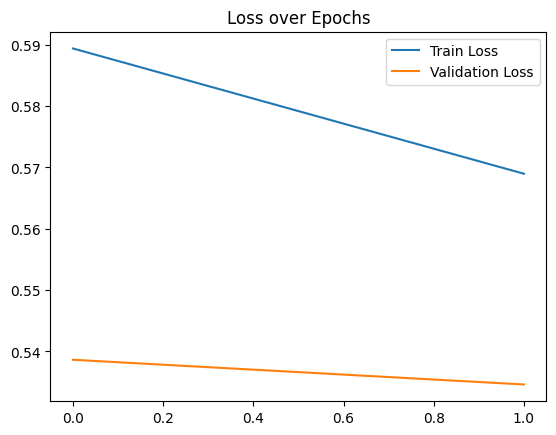

In [30]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

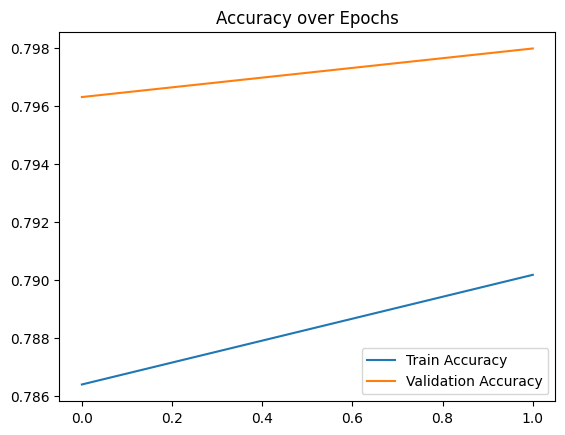

In [31]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

In [ ]:
y_val_preds = np.argmax(nn_model.predict(X_nn_val), axis=1)

10920/10920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


NameError: name 'confusion_matrix' is not defined

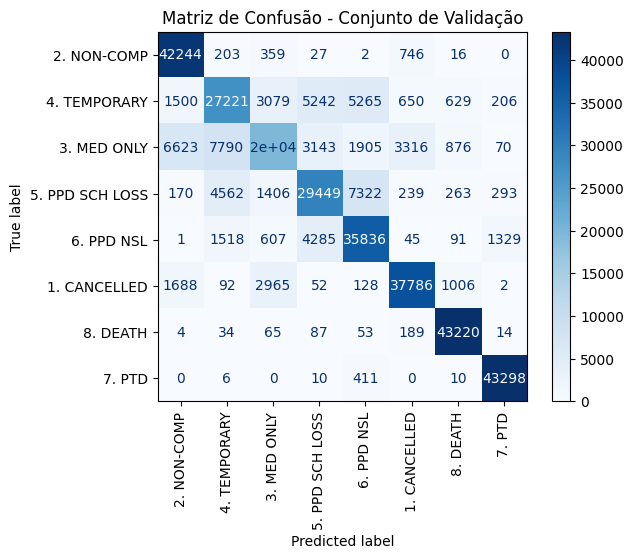

In [34]:
conf_matrix = confusion_matrix(y_nn_val, y_val_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=list(mapa_codificacao.values()))
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.title("Matriz de Confusão - Conjunto de Validação")
plt.show()

In [35]:
report = classification_report(y_nn_val, y_val_preds, target_names=list(mapa_codificacao.values()))
print(report)

                 precision    recall  f1-score   support

    2. NON-COMP       0.81      0.97      0.88     43597
   4. TEMPORARY       0.66      0.62      0.64     43792
    3. MED ONLY       0.70      0.45      0.55     43511
5. PPD SCH LOSS       0.70      0.67      0.68     43704
     6. PPD NSL       0.70      0.82      0.76     43712
   1. CANCELLED       0.88      0.86      0.87     43719
       8. DEATH       0.94      0.99      0.96     43666
         7. PTD       0.96      0.99      0.97     43735

       accuracy                           0.80    349436
      macro avg       0.79      0.80      0.79    349436
   weighted avg       0.79      0.80      0.79    349436



In [36]:
mapa_codificacao = {
    0: '2. NON-COMP',
    1: '4. TEMPORARY',
    2: '3. MED ONLY',
    3: '5. PPD SCH LOSS',
    4: '6. PPD NSL',
    5: '1. CANCELLED',
    6: '8. DEATH',
    7: '7. PTD'
}

claim_ids = data_test_FS["Claim Identifier"]

final_test_predictions = nn_model.predict(test_predictions)
final_test_labels = np.argmax(final_test_predictions, axis=1)


final_test_labels_coded = [mapa_codificacao[label] for label in final_test_labels]

results = pd.DataFrame({
    "Claim Identifier": claim_ids,
    "Claim Injury Type": final_test_labels_coded
})

results.to_csv("../predictions/group_40_KFold_CatBoost_NN_predictions.csv", index=False)
print("Predições salvas em '../predictions/group_40_KFold_CatBoost_NN_predictions.csv'.")


12125/12125 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Predições salvas em '../predictions/group_40_KFold_CatBoost_NN_predictions.csv'.


In [37]:
predicitons_data = pd.read_csv('../predictions/group_40_KFold_CatBoost_NN_predictions.csv')
values = predicitons_data['Claim Injury Type'].value_counts()

values

Claim Injury Type
2. NON-COMP        317984
4. TEMPORARY        49811
1. CANCELLED         9155
3. MED ONLY          7931
5. PPD SCH LOSS      3081
8. DEATH               13
Name: count, dtype: int64